### __6. Putting it all together__


In [14]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.3.1'

Create device-agnostic code

If GPU is available, our code will use it, if not, then code defaults to CPU.

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### __6.1 Data__

In [16]:
#Create some data using the linear regression formula
weight = .7
bias = .3

#Create range values
start = 0
end = 1
step = .02
X = torch.arange(start, end, step).unsqueeze(dim=1) #capital letter to represent a matrix/tensor
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [17]:
# Split Data
train_split = int(.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

`plot_predictions()` takes in training data and labels to display a graph showing the model's predictions if given an input

In [18]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

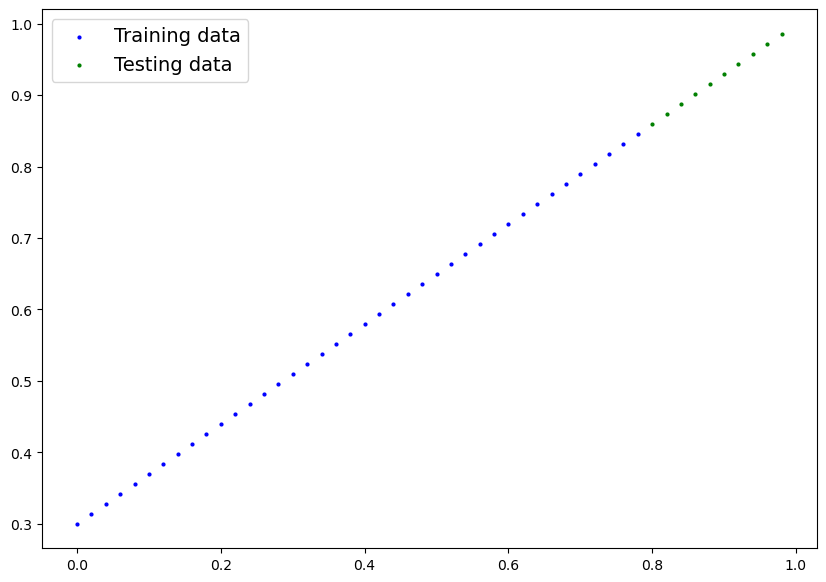

In [19]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

### __6.2 Building a PyTorch Linear Model__

In [20]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModel(nn.Module): #<--- subclassing
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1) # take an input of size 1, to produce an output of size 1
        
        # Override the forward() method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [21]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

### __6.3 Training__

For training we need...
* Loss Function
* Optimizer
* Training Loop
* Testing Loop

In [22]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=.01)

In [23]:
# Training loop time
torch.manual_seed(42)

epochs = 200

# Put data on target device (device-agnostic code for target device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train)
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad (to reset optimizer step to 0 each time instead of accumulating)
    optimizer.zero_grad()
    
    # 4. Perform backpropagation
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
        
    # Print out the loop
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.002787243574857712 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.01380180753767

In [24]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

### __6.4 Making and evaluating predictions__

In [25]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds



tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

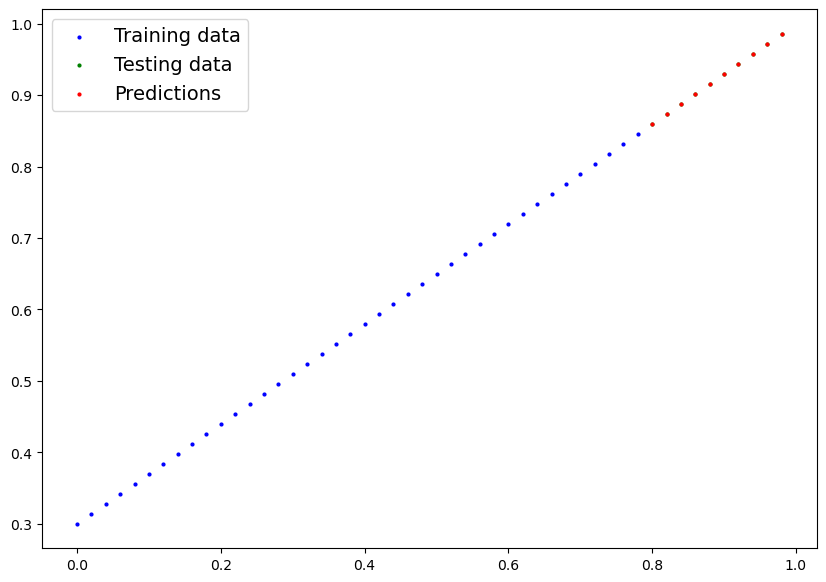

In [26]:
# Check out the model's predictions visually
plot_predictions(predictions=y_preds.cpu())

### __6.5 Saving & Loading a trained model__

In [27]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [28]:
# Load a PyTorch model

# Create a new instance of linear regression model
loaded_model = LinearRegressionModel()

# Load the saved model_1 state dict
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [29]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])